In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [8]:
import chardet
import pandas as pd

file_path = "rental_data_中新.csv"

# 检测文件编码
with open(file_path, "rb") as f:
    raw_data = f.read(10000)  # 读取前 10KB 数据进行检测
    result = chardet.detect(raw_data)
    detected_encoding = result["encoding"]
    print(f"检测到的文件编码: {detected_encoding}")

# 用检测到的编码读取 CSV
df_zhongxin_rent = pd.read_csv(file_path, encoding=detected_encoding)


检测到的文件编码: utf-8


In [9]:
###################################
# 1. 数据收集与合并
###################################

# 读取租价数据
df_zhongxin_rent = pd.read_csv('rental_data_中新.csv', encoding="utf-8")
df_wuqing_rent = pd.read_csv('rental_data_武清.csv', encoding="utf-8")
df_balitai_rent = pd.read_csv('rental_data_八里台.csv', encoding="utf-8")
df_quanyechang_rent = pd.read_csv('rental_data_劝业场.csv', encoding="utf-8")


In [10]:
# 在每个数据表中添加 location 标识
df_zhongxin_rent['location'] = 'Zhongxin'
df_wuqing_rent['location'] = 'Wuqing'
df_balitai_rent['location'] = 'BaliTai'
df_quanyechang_rent['location'] = 'Quanyechang'

In [11]:
# 纵向合并（租价数据）
rent_all = pd.concat([df_zhongxin_rent, df_wuqing_rent, df_balitai_rent,df_quanyechang_rent], ignore_index=True)

In [12]:

# 读取售价数据
df_zhongxin_sale = pd.read_csv('selling_data_中新.csv', encoding="utf-8")
df_wuqing_sale = pd.read_csv('selling_data_武清.csv', encoding="utf-8")
df_balitai_sale = pd.read_csv('selling_data_八里台.csv', encoding="utf-8")
df_quanyechang_sale = pd.read_csv('selling_data_劝业场.csv', encoding="utf-8")
# 在每个数据表中添加 location 标识
df_zhongxin_sale['location'] = 'Zhongxin'
df_wuqing_sale['location'] = 'Wuqing'
df_balitai_sale['location'] = 'BaliTai'
df_quanyechang_sale['location'] = 'Quanyechang'
# 纵向合并（售价数据）
sale_all = pd.concat([df_zhongxin_sale, df_wuqing_sale, df_balitai_sale,df_quanyechang_sale], ignore_index=True)

In [13]:
###################################
# 2. 数据描述与异常值检查
###################################

# 查看租价数据基本信息
print("===== 租价数据描述 =====")
print(rent_all.describe())

# 查看售价数据基本信息
print("\n===== 售价数据描述 =====")
print(sale_all.describe())

===== 租价数据描述 =====
             面积(㎡)      月租金(元/月)
count  1061.000000   1061.000000
mean     99.060320   4030.767201
std      55.642645   4365.730253
min      10.000000    500.000000
25%      67.000000   2000.000000
50%      90.000000   3000.000000
75%     118.000000   4500.000000
max     633.000000  55000.000000

===== 售价数据描述 =====
            平方数(㎡)        总价（万）        单价（元/㎡）
count  9225.000000  9225.000000    9225.000000
mean     77.969927   276.058536   45040.866992
std      57.202511   232.349129   25331.313986
min       4.800000    24.000000    4190.000000
25%      34.660000   128.000000   22962.000000
50%      63.950000   230.000000   46026.000000
75%     107.840000   340.000000   60422.000000
max     673.850000  3960.000000  188802.000000


In [14]:
###################################
# 3. 计算价格和租金（单位面积）
###################################

# 对租价数据，计算每平米月租 (rent_per_m2)
# 假设 rent_all 中有列 'rent' 表示总月租金，'m2' 表示面积
rent_all['rent_per_m2'] = rent_all['月租金(元/月)'] / rent_all['面积(㎡)']

# 对售价数据，计算每平米售价 (price_per_m2)
# 如果已经有单位售价列(如 'unit_price')，可以直接使用；否则用 price/m2 计算
# 这里假设我们不依赖 unit_price，直接自己算
sale_all['price_per_m2'] = sale_all['单价（元/㎡）']

# 检查是否正确
print("\n===== 租价数据（含 rent_per_m2） =====")
print(rent_all.head())

print("\n===== 售价数据（含 price_per_m2） =====")
print(sale_all.head())


===== 租价数据（含 rent_per_m2） =====
   面积(㎡)  月租金(元/月)  location  rent_per_m2
0   89.0    3000.0  Zhongxin    33.707865
1   83.0    2800.0  Zhongxin    33.734940
2  135.0    4000.0  Zhongxin    29.629630
3   94.0    3200.0  Zhongxin    34.042553
4   80.0    2800.0  Zhongxin    35.000000

===== 售价数据（含 price_per_m2） =====
   平方数(㎡)  总价（万）  单价（元/㎡）  location  price_per_m2
0   89.50   80.0   8938.0  Zhongxin        8938.0
1   83.00  120.0  14457.0  Zhongxin       14457.0
2   76.00   65.0   8552.0  Zhongxin        8552.0
3   89.47   85.0   9500.0  Zhongxin        9500.0
4   98.00   85.0   8673.0  Zhongxin        8673.0


In [15]:
###################################
# 4. 计算房价与租金比（中位数）
###################################

# 分别计算各街区的房价中位数（price/m2）与租金中位数（rent/m2）
median_price = sale_all.groupby('location')['price_per_m2'].median()
median_rent = rent_all.groupby('location')['rent_per_m2'].median()

# 计算 ratio = median_price / median_rent
location_ratio = median_price / median_rent
print("\n===== 各街区房价与租金比（中位数） =====")
print(location_ratio)


===== 各街区房价与租金比（中位数） =====
location
BaliTai        660.636145
Quanyechang    820.214115
Wuqing         671.986291
Zhongxin       559.884600
dtype: float64


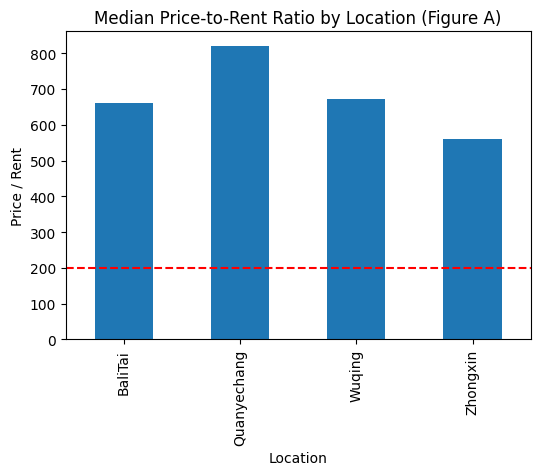

In [16]:
###################################
# 5. 绘制柱状图 (Figure A)
#    每个街区的房价与租金比
###################################

plt.figure(figsize=(6,4))
location_ratio.plot(kind='bar')
plt.title('Median Price-to-Rent Ratio by Location (Figure A)')
plt.ylabel('Price / Rent')
plt.xlabel('Location')
plt.axhline(y=200, color='r', linestyle='--')  # 全球公平值约为200，可做参考线
plt.show()

In [22]:
sale_all.rename(columns={"平方数(㎡)": "m2"}, inplace=True)
rent_all.rename(columns={"面积(㎡)": "m2"}, inplace=True)


In [24]:
###################################
# 6. 建立回归模型
#
# 模型 1（预测房价 price/m²）： 
#   price_per_m2_i = β0 + β1*m2_i + β2*location_i + β3*(m2_i×location_i) + εi
#
# 模型 2（预测租金 rent/m²）： 
#   rent_per_m2_i = β0 + β1*m2_i + β2*location_i + β3*(m2_i×location_i) + εi
#
# location_i 为分类变量，可通过哑变量自动处理
###################################

# 使用 statsmodels 库，通过公式接口建模
# 在公式中使用 C(location) 表示将 location 视作分类变量，同时使用 m2*C(location) 表示交互项
model_price = smf.ols("price_per_m2 ~ m2 * C(location)", data=sale_all).fit()
model_rent = smf.ols("rent_per_m2 ~ m2 * C(location)", data=rent_all).fit()

print("\n===== 模型 1 回归结果（price_per_m2） =====")
print(model_price.summary())

print("\n===== 模型 2 回归结果（rent_per_m2） =====")
print(model_rent.summary())


===== 模型 1 回归结果（price_per_m2） =====
                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     2387.
Date:                Thu, 20 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:17:41   Log-Likelihood:            -1.0186e+05
No. Observations:                9225   AIC:                         2.037e+05
Df Residuals:                    9217   BIC:                         2.038e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [29]:
###################################
# 7. 使用模型预测：
#    预测 m2 = 50 和 m2 = 100 时，不同 location 的房价和租金
###################################

# 构造用于预测的 DataFrame（不同 m2，不同 location）
predict_df = pd.DataFrame({
    'm2': [50, 50, 50, 50,100, 100, 100,100],
    'location': ['Zhongxin', 'Wuqing', 'BaliTai', 'Quanyechang','Zhongxin', 'Wuqing', 'BaliTai','Quanyechang']
})

pred_price = model_price.predict(predict_df)
pred_rent = model_rent.predict(predict_df)

# 将预测结果合并到一个表格中方便查看
predict_df['pred_price_per_m2'] = pred_price
predict_df['pred_rent_per_m2'] = pred_rent
predict_df['price_rent_ratio'] = predict_df['pred_price_per_m2'] / predict_df['pred_rent_per_m2']

print("\n===== 不同 m2 与 location 的预测结果 =====")
print(predict_df)


===== 不同 m2 与 location 的预测结果 =====
    m2     location  pred_price_per_m2  pred_rent_per_m2  price_rent_ratio
0   50     Zhongxin       12393.610314         26.685543        464.431637
1   50       Wuqing       10891.997258         16.016731        680.038730
2   50      BaliTai       22938.060409         39.824863        575.973373
3   50  Quanyechang       59687.426136         66.663876        895.348877
4  100     Zhongxin       13954.408016         25.413446        549.095462
5  100       Wuqing       11732.536273         17.401354        674.231230
6  100      BaliTai       28632.361746         43.208759        662.651797
7  100  Quanyechang       51764.833891         67.838039        763.065013


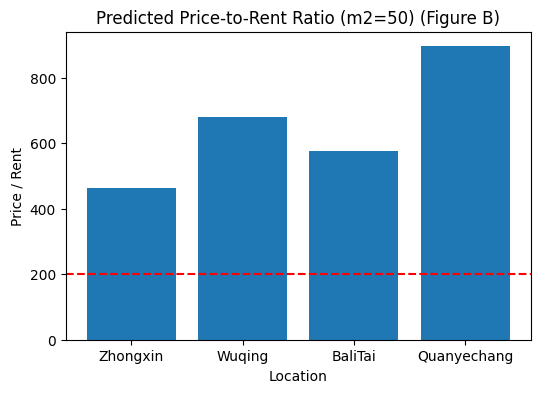

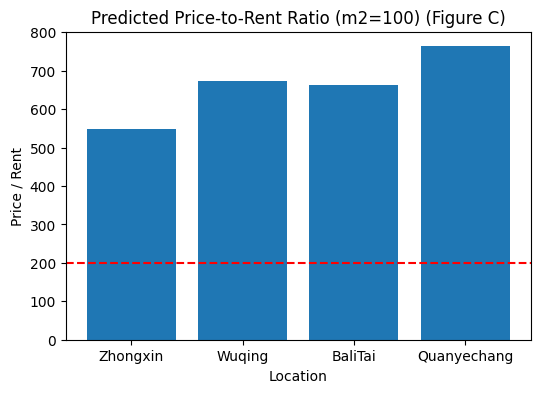

In [30]:
###################################
# 8. 绘制柱状图 (Figure B, Figure C)
#    绘制在 m2=50 和 m2=100 时，各地点的 price/rent 比率
###################################

# 分别筛选 m2=50 和 m2=100 的预测数据
df_50 = predict_df[predict_df['m2'] == 50]
df_100 = predict_df[predict_df['m2'] == 100]

# Figure B: m2=50
plt.figure(figsize=(6,4))
plt.bar(df_50['location'], df_50['price_rent_ratio'])
plt.title('Predicted Price-to-Rent Ratio (m2=50) (Figure B)')
plt.ylabel('Price / Rent')
plt.xlabel('Location')
plt.axhline(y=200, color='r', linestyle='--')  # 参考线
plt.show()

# Figure C: m2=100
plt.figure(figsize=(6,4))
plt.bar(df_100['location'], df_100['price_rent_ratio'])
plt.title('Predicted Price-to-Rent Ratio (m2=100) (Figure C)')
plt.ylabel('Price / Rent')
plt.xlabel('Location')
plt.axhline(y=200, color='r', linestyle='--')  # 参考线
plt.show()